<a href="https://colab.research.google.com/github/Kaveeshakavindi/Adventura/blob/main/sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

In [2]:
!pip install chardet

In [3]:
import pandas as pd
import chardet
import re
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, AutoConfig, AutoModel, BertForSequenceClassification, AdamW, BertModel
import tensorflow as tf
from torch.nn import DataParallel
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
Data = pd.read_csv("train.txt",header=None, sep=";", names=["Text", "Emotion"], encoding="utf-8")

In [5]:
# Split the data into train, validation and test
Train, temp_set = train_test_split(Data, test_size=0.5, random_state=42)

# Further splitting temp_set into validation and test sets
Valid, Test = train_test_split(temp_set, test_size=0.5, random_state=42)

In [6]:
Data['Emotion'].value_counts()

Emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

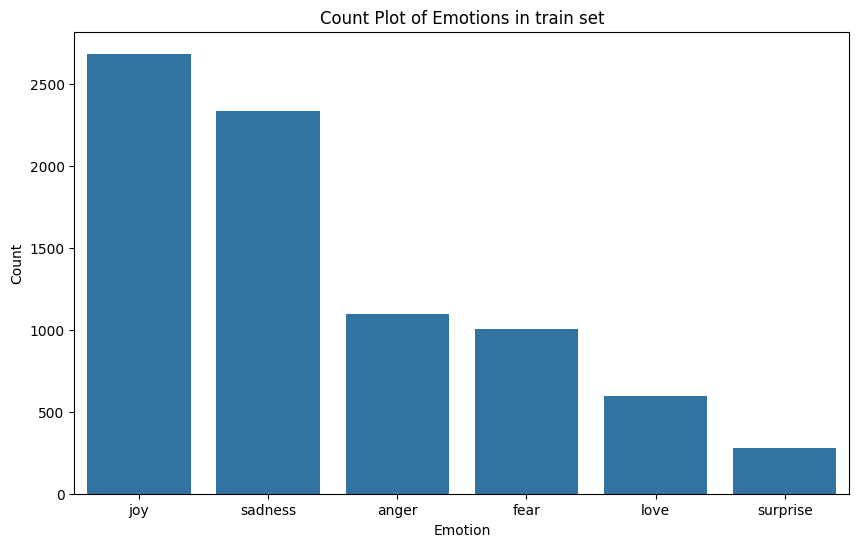

In [7]:
# check the class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Emotion', data=Train, order=Train['Emotion'].value_counts().index)
plt.title('Count Plot of Emotions in train set')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

In [8]:
print(Train.isnull().any())
print(Valid.isnull().any())
print(Test.isnull().any())

Text       False
Emotion    False
dtype: bool
Text       False
Emotion    False
dtype: bool
Text       False
Emotion    False
dtype: bool


In [9]:
def clean_text(text):
    # ensure there is no other character other than alphabets
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    return text

In [10]:
Train['Text'] = Train['Text'].apply(clean_text)
Valid['Text'] = Valid['Text'].apply(clean_text)
Test['Text'] = Test['Text'].apply(clean_text)

In [11]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
def tokenize_text(text):
    # Tokenize the text using the BERT tokenizer
    tokenized_text = tokenizer(text)
    return tokenized_text

In [13]:
from datasets import Dataset
from torch.utils.data import DataLoader

class Create_Dataset(Dataset):
    def __init__(self, tokenized_texts, labels):
        labels_to_idx = {'joy':0,'sadness':1,'anger':2,'fear':3,'love':4,'surprise':5}
        self.tokenized_texts = tokenized_texts
        self.labels = [labels_to_idx[label] for label in labels]
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if isinstance(idx, int):
            idx = [idx]  # Convert single index to list for batch processing
        return {
        'input_ids': [self.tokenized_texts[i]['input_ids'] for i in idx],
        'attention_mask': [self.tokenized_texts[i]['attention_mask'] for i in idx],
        'labels': [self.labels[i] for i in idx]
    }


    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

    def __repr__(self):
        return f"Create_Dataset(num_samples={len(self.labels)})"

In [14]:
texts_train = Train['Text'].apply(tokenize_text).tolist()

texts_train = texts_train
labels_train = Train['Emotion'].tolist()

texts_val = Valid['Text'].apply(tokenize_text).tolist()
labels_val = Valid['Emotion'].tolist()

texts_test = Test['Text'].apply(tokenize_text).tolist()
labels_test = Test['Emotion'].tolist()

Train_dataset = Create_Dataset(texts_train, labels_train)
Val_dataset = Create_Dataset(texts_val, labels_val)
Test_dataset = Create_Dataset(texts_test, labels_test)

In [15]:
Train_dataloader = DataLoader(
    Train_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=data_collator
)

Val_dataloader = DataLoader(
    Val_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=data_collator
)

Test_dataloader = DataLoader(
    Test_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=data_collator
)

In [16]:
config = AutoConfig.from_pretrained("google-bert/bert-base-uncased", num_labels=6)

Bert_classifier = BertForSequenceClassification.from_pretrained("google-bert/bert-base-uncased",config = config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
Bert_classifier

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [18]:
import os
class CSVLogger:
    def __init__(self, filename, fieldnames):
        self.filename = filename
        self.fieldnames = fieldnames
        self.is_first_row = not os.path.exists(filename)
        self.df = pd.DataFrame(columns=self.fieldnames)
        self.df.to_csv(self.filename, index=False)

    def log(self, values):
        self.df.loc[len(self.df)]=values
        self.df.to_csv(self.filename,index=False)
        self.is_first_row = False

    def close(self):
        pass  # Nothing to do for closing a Pandas-based logger

names = ['epoch', 'train_loss', 'train_acc',
         'val_loss', 'val_acc']

CSV_logger = CSVLogger('training_logs.csv', fieldnames=names)

In [23]:
import torch
import tensorflow as tf
from torch.nn import DataParallel

def train_loop(model, optimizer, Trainloader, Val_loader, Epochs=10):
    #Criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    # Use CPU instead of CUDA
    device = torch.device("cpu")  # Use CPU
    model = model.to(device)
    #model = DataParallel(model)
    prev_best_loss = float('inf')

    for epoch in range(Epochs):  # loop over the dataset multiple times
        print(f"Epoch {epoch+1}")

        # Training phase
        model.train()  # Set the model to training mode
        train_loss = 0.0
        train_acc = 0.0

        progress_bar = tf.keras.utils.Progbar(len(Trainloader))

        for i, batch in enumerate(Trainloader):
            # Send data to CPU
            batch = {k: v.to(device) for k, v in batch.items()}

            optimizer.zero_grad()
            outputs = model(**batch)

            logits = outputs.logits
            loss = outputs.loss

            loss.backward()
            optimizer.step()

            train_loss = (train_loss * i + loss.item()) / (i + 1)
            train_acc = (train_acc * i + ((torch.argmax(logits, axis=-1) == batch['labels']).sum().item()) / batch['labels'].size(0)) / (i + 1)

            # Update progress bar
            progress_bar.update(i + 1, [('train_loss', train_loss), ('train_acc', train_acc)])

            del outputs
            del logits
            del loss
            del batch

            torch.cuda.empty_cache()

        # Validation phase
        model.eval()  # Set the model to evaluation mode

        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            progress_bar = tf.keras.utils.Progbar(len(Val_loader))
            for i, batch in enumerate(Val_loader):
                # Send data to CPU
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)

                logits = outputs.logits
                loss = outputs.loss

                val_loss = (val_loss * i + loss.item()) / (i + 1)
                val_acc = (val_acc * i + ((torch.argmax(logits, axis=-1) == batch['labels']).sum().item()) / batch['labels'].size(0)) / (i + 1)

                progress_bar.update(i + 1, [('val_loss', val_loss), ('val_acc', val_acc)])

                del outputs
                del logits
                del loss
                del batch

                torch.cuda.empty_cache()

        logs = {'epoch': epoch, 'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc}
        CSV_logger.log(logs)

        # Print statistics
        print(f"Val Loss: {val_loss}")

In [24]:
import torch
optimizer = AdamW(Bert_classifier.parameters(), lr=2e-5, correct_bias=False, no_deprecation_warning=True)

In [25]:
trained_model = train_loop(Bert_classifier, optimizer, Train_dataloader ,Val_dataloader, Epochs=5)

Epoch 1
250/250 [==============================] - 549s 2s/step - val_loss: 0.1888 - val_acc: 0.9283
Val Loss: 0.1934735494554043
Epoch 2
250/250 [==============================] - 553s 2s/step - val_loss: 0.1686 - val_acc: 0.9327
Val Loss: 0.1739539499748498
Epoch 3
250/250 [==============================] - 550s 2s/step - val_loss: 0.1758 - val_acc: 0.9271
Val Loss: 0.1881521705379709
Epoch 4
250/250 [==============================] - 551s 2s/step - val_loss: 0.1860 - val_acc: 0.9252
Val Loss: 0.19193687388859695
Epoch 5
250/250 [==============================] - 556s 2s/step - val_loss: 0.2098 - val_acc: 0.9258
Val Loss: 0.22037626512697897


In [27]:
log = pd.read_csv("training_logs.csv")
log

,epoch,train_loss,train_acc,val_loss,val_acc
0,0,0.499421,0.826625,0.193474,0.92575
1,1,0.135766,0.945125,0.173954,0.93000
2,2,0.094034,0.958375,0.188152,0.92500
3,3,0.071100,0.969125,0.191937,0.92550
4,4,0.055973,0.977625,0.220376,0.92700


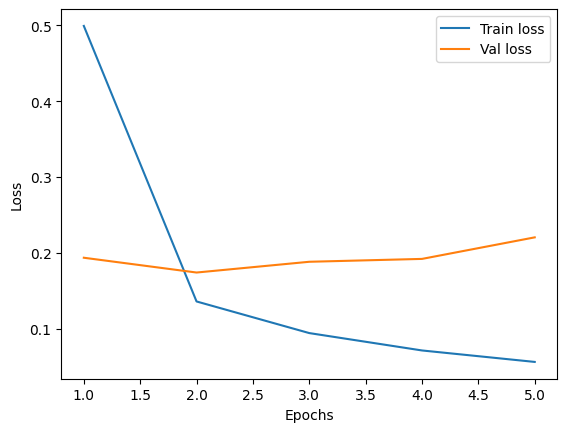

In [28]:
plt.plot(log['epoch']+1,log['train_loss'],label='Train loss')
plt.plot(log['epoch']+1,log['val_loss'], label = 'Val loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

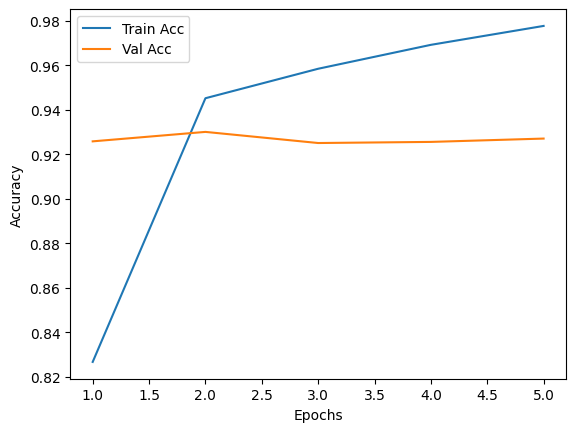

In [29]:
plt.plot(log['epoch']+1,log['train_acc'],label='Train Acc')
plt.plot(log['epoch']+1,log['val_acc'], label = 'Val Acc')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [30]:
def evaluate(model, dataloader):
    test_loss = 0.0
    test_acc = 0.0
    progress_bar = tf.keras.utils.Progbar(len(dataloader))
    pred = []
    y_true = []
    model.eval()
    with torch.no_grad():
        progress_bar = tf.keras.utils.Progbar(len(dataloader))
        for i, batch in enumerate(dataloader):
            outputs = model(**batch)

            logits = outputs.logits
            loss = outputs.loss

            test_loss = (test_loss * i + loss.item()) / (i + 1)
            test_acc = (test_acc * i + ((torch.argmax(logits, axis=-1) == batch['labels']).sum().item()) / batch['labels'].size(0)) / (i + 1)
            pred.extend(torch.argmax(logits, axis=-1).numpy())
            y_true.extend(batch['labels'].numpy())
            progress_bar.update(i + 1, [('test_loss', test_loss), ('test_acc', test_acc)])


    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    return pred,y_true

In [33]:
Bert_classifier = Bert_classifier.to('cpu')# transfer the model to CPU

In [34]:
pred,y_true = evaluate(Bert_classifier,Test_dataloader)

250/250 [==============================] - 552s 2s/step - test_loss: 0.2567 - test_acc: 0.9210
Test Loss: 0.2454, Test Acc: 0.9235


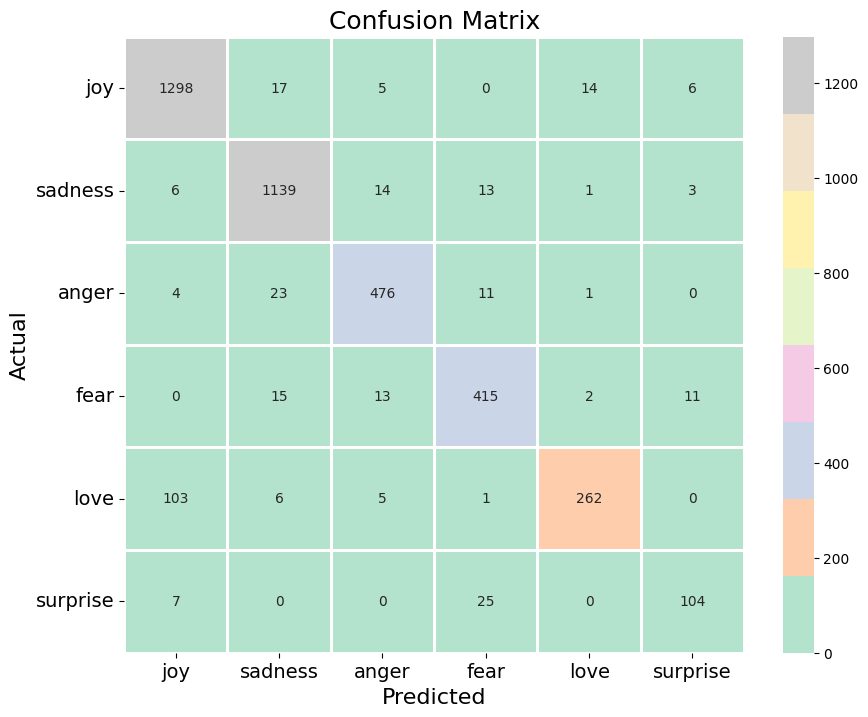

In [36]:
import numpy as np
from sklearn.metrics import confusion_matrix
index_to_labels = ['joy','sadness','anger','fear','love','surprise']

def Confusion_matrix(y_true,y_pred):
    labels = np.unique(y_true)
    CM = confusion_matrix(y_true, y_pred)
    plt.figure(figsize = (10, 8))
    plt.title(f"Confusion Matrix", fontsize=18)
    sns.heatmap(CM, annot = True, cmap = 'Pastel2', fmt = 'd', linewidths = 1.0)
    plt.yticks(np.arange(len(index_to_labels)) + 0.5, index_to_labels, fontsize = 14, rotation = 'horizontal')
    plt.xticks(np.arange(len(index_to_labels)) + 0.5, index_to_labels, fontsize = 14)
    plt.xlabel("Predicted", fontsize = 16)
    plt.ylabel("Actual", fontsize = 16)
    plt.show()

Confusion_matrix(y_true,pred)